In [74]:
from langgraph.graph import StateGraph , START , END
from typing import TypedDict , Literal , List , Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
from dotenv import load_dotenv
from pydantic import BaseModel , Field
import operator

load_dotenv()

True

In [75]:
generator = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
optimizer = ChatGoogleGenerativeAI(model="gemini-2.5-pro")
evaluator = ChatGoogleGenerativeAI(model="gemini-2.5-pro")

In [76]:
class Structure_evaluator(BaseModel):
    evaluation: Literal['approved', 'needs_improvement'] = Field(..., description="Indicates whether the tweet is approved or needs improvement.")
    feedback: str = Field(description= 'Jot down the feedback of Text with 30 words')

In [77]:
structuring_llm= evaluator.with_structured_output(Structure_evaluator)

In [78]:
class Tweet(TypedDict):
    topic: str
    tweet : str
    max_iteration : int
    evaluation: Literal["approved", "needs_improvement"]

    feedback: str
    iteration: int
    # tweet_history: Annotated[List[str] , operator.add]
    # feedback_history: Annotated[List[str] , operator.add]


In [79]:
def generate_text(state: Tweet) -> Tweet :
    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
        Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

        Rules:
        - Do NOT use question-answer format.
        - Max 280 characters.
        - Use observational humor, irony, sarcasm, or cultural references.
        - Think in meme logic, punchlines, or relatable takes.
        - Use simple, day to day english
        """)
        ]
    
    result= generator.invoke(messages).content
    return {'tweet':result}


def evaluator(state: Tweet) -> Tweet:
    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),

    HumanMessage(content=f"""
    Evaluate the following tweet:

    Tweet: "{state['tweet']}"

    Use the criteria below to evaluate the tweet:

    1. Originality – Is this fresh, or have you seen it a hundred times before?  
    2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
    3. Punchiness – Is it short, sharp, and scroll-stopping?  
    4. Virality Potential – Would people retweet or share it?  
    5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

    Auto-reject if:
    - It's written in question-answer format (e.g., "Why did..." or "What happens when...")
    - It exceeds 280 characters
    - It reads like a traditional setup-punchline joke
    - Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

    ### Respond ONLY in structured format:
    - evaluation: "approved" or "needs_improvement"  
    - feedback: One paragraph explaining the strengths and weaknesses 
    """)
    ]
    result= structuring_llm.invoke(messages)
    return {'evaluation': result.evaluation,'feedback':result.feedback}


def optimizer(state: Tweet) -> Tweet:
    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
        Improve the tweet based on this feedback:
        "{state['feedback']}"

        Topic: "{state['topic']}"
        Original Tweet:
        {state['tweet']}

        Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
        """)
        ]
    iterations= state['iteration'] + 1

    messages = optimizer.invoke(messages).content
    state['iteration'] = iterations
    return {'tweet' : messages , 'iteration': iterations}




def condition(state: Tweet) -> Literal['approved', 'needs_improvement']:
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

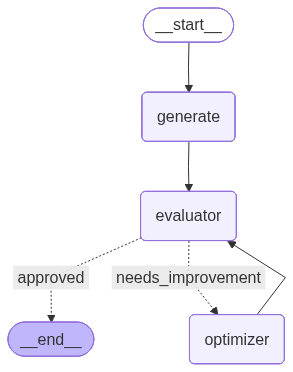

In [80]:
graph = StateGraph(Tweet)
graph.add_node('generate' , generate_text)
graph.add_node('optimizer', optimizer)
graph.add_node('evaluator', evaluator)

graph.add_edge(START , 'generate')
graph.add_edge('generate','evaluator')
graph.add_conditional_edges('evaluator' , condition , {'approved' : END , 'needs_improvement' : 'optimizer'})
graph.add_edge('optimizer' , 'evaluator')
graph.compile()

In [81]:
initial_graph= {'topic': 'Education System' , 
'max_iteration':5,
'iteration': 1}
workflow= graph.compile() # Do not directly call compile().invoke it may causes error
final_graph= workflow.invoke(initial_graph)

In [82]:
final_graph

{'topic': 'Education System', 'tweet': "My education system taught me how to diagram a sentence but not how to fix a leaky faucet. Pretty sure I'll use the faucet skill more. 🤷\u200d♀️ #EducationSystem #AdultingFail", 'max_iteration': 5, 'evaluation': 'approved', 'feedback': 'This tweet gets a pass. Its strength is in its high relatability, tapping into a shared frustration with the education system. The format is clean, and it has decent virality potential. However, the core concept is completely unoriginal; the “school taught me useless things instead of practical skills” trope is tired. It’s a relatable chuckle, not a fresh comedic take. Solid, but not groundbreaking.', 'iteration': 1}

In [83]:
from pprint import pprint
pprint(final_graph['tweet'])

('My education system taught me how to diagram a sentence but not how to fix a '
 "leaky faucet. Pretty sure I'll use the faucet skill more. 🤷\u200d♀️ "
 '#EducationSystem #AdultingFail')


In [86]:
final_graph['feedback']

'This tweet gets a pass. Its strength is in its high relatability, tapping into a shared frustration with the education system. The format is clean, and it has decent virality potential. However, the core concept is completely unoriginal; the “school taught me useless things instead of practical skills” trope is tired. It’s a relatable chuckle, not a fresh comedic take. Solid, but not groundbreaking.'